In [135]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [149]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


Проверяем наши даннные

In [46]:
osetr_paths = [
    os.path.join('Tensorflow', 'workspace', 'data', 'осетр 24.11 (1).21', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'осетр после опыта 2022', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'осетры пруды 2022', '')
]

karp_paths = [
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 один', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 два', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 три', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 четыре', '')
]

In [78]:
def count_classes(directory_path):
    class_counts = {}
    for path in directory_path:
        for filename in os.listdir(path):
            if filename.endswith('.xml'):
                tree = ET.parse(os.path.join(path, filename))
                root = tree.getroot()
    
                objects = root.findall('object')
                for object in objects:
                    name = object.find('name').text
                    if name in class_counts:
                        class_counts[name] += 1
                    else:
                        class_counts[name] = 1
    return class_counts

In [81]:
osetr_classes = count_classes(osetr_paths)

In [82]:
karp_classes = count_classes(karp_paths)

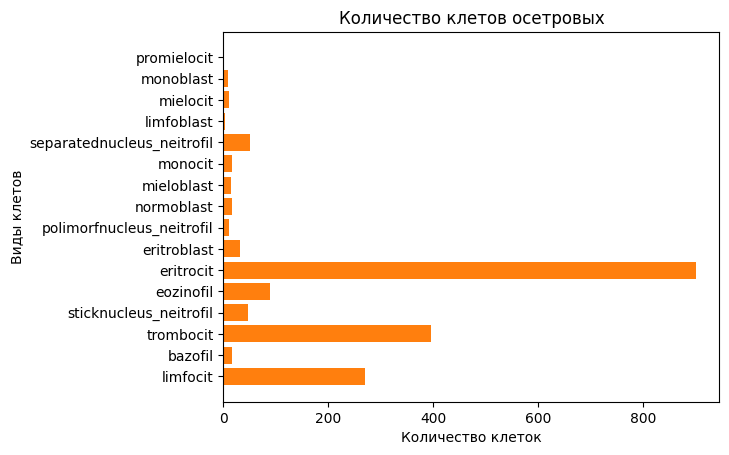

In [132]:
# Extract class counts from the dictionary
class_names = list(osetr_classes.keys())
class_counts = list(osetr_classes.values())

# Create a bar plot
plt.barh(class_names, class_counts, color='tab:orange')
plt.xlabel("Количество клеток")
plt.ylabel("Виды клетов")
plt.title("Количество клетов осетровых")
plt.show()

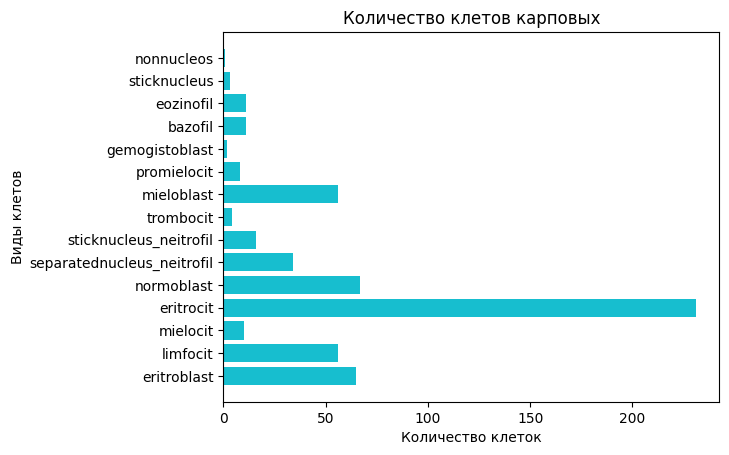

In [133]:
# Extract class counts from the dictionary
class_names = list(karp_classes.keys())
class_counts = list(karp_classes.values())

# Create a bar plot
plt.barh(class_names, class_counts, color='tab:cyan')
plt.xlabel("Количество клеток")
plt.ylabel("Виды клетов")
plt.title("Количество клетов карповых")
plt.show()

In [143]:
os.path.join('Tensorflow', 'data', 'osetr', 'train', '1 ленский-1.jpg')

'Tensorflow/data/osetr/train/1 ленский-1.jpg'

Пример вывода изображения 

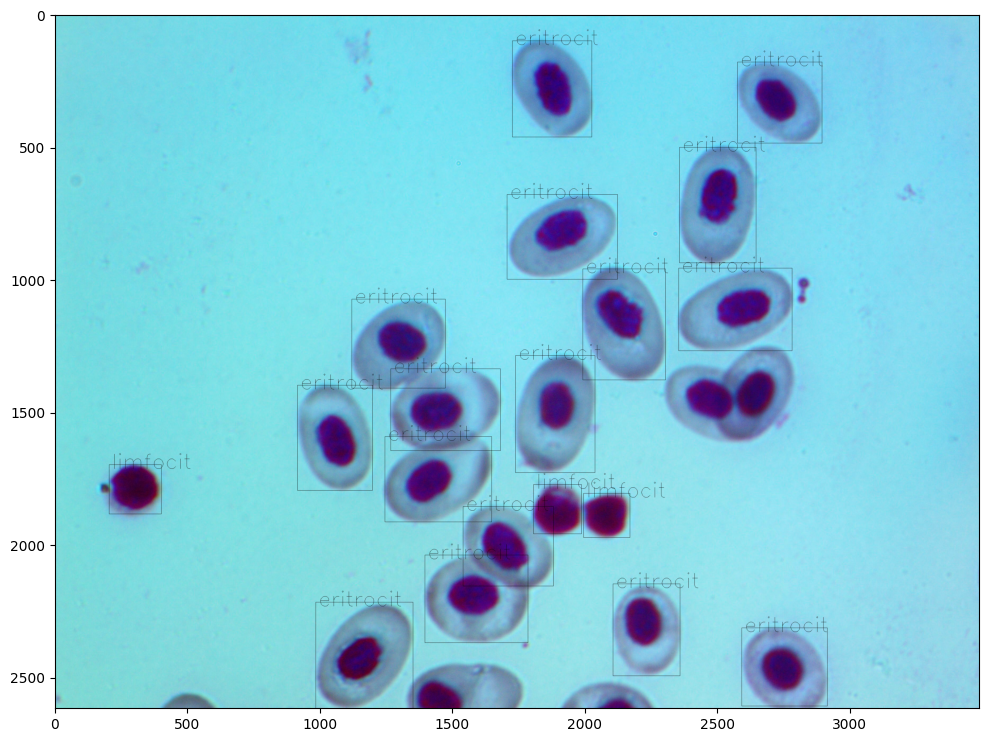

In [147]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread(os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'train', '1 ленский-1.jpg'))
tree = ET.parse(os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'train', '1 ленский-1.xml'))
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                cv2.rectangle(image, (xmin, ymin),
                            (xmax, ymax), (0, 0, 0), 1)
                cv2.putText(image, name, (xmin + 10, ymin + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 0), 1)
plt.figure(figsize=(16,9))
plt.imshow(image)
plt.show()

Генерируем label_map.pbtxt

In [2]:
TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'train', '')
TEST_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'test', '')

In [3]:
def parse_xml(filename):
    with open(filename) as f:
        tree = ET.parse(f)
        root = tree.getroot()

        classes = set()
        for obj in root.findall('object'):
            name = obj.find('name').text
            classes.add(name)

        return classes

def create_label_map(classes, path_to_data):
    classes = list(classes)
    with open(path + 'label_map.pbtxt', 'w') as f:
        f.write('item {\n')
        f.write(' id: 1\n')
        f.write(' name: \"%s\"\n' % classes[0])
        f.write('}\n')

        for i in range(1, len(classes)):
            f.write('item {\n')
            f.write(' id: %d\n' % (i + 1))
            f.write(' name: \"%s\"\n' % classes[i])
            f.write('}\n')

if __name__ == '__main__':
    classes = set()
    paths = [TRAIN_PATH, TEST_PATH]
    for path in paths:
        for filename in os.listdir(path):
            if filename.endswith('.xml'):
                classes.update(parse_xml(path + '%s' % filename))
        print(classes, len(classes))
        create_label_map(classes, path)

{'bazofil', 'eozinofil', 'limfocit', 'polimorfnucleus_neitrofil', 'normoblast', 'sticknucleus_neitrofil', 'trombocit', 'monoblast', 'mieloblast', 'limfoblast', 'eritrocit', 'promielocit', 'separatednucleus_neitrofil', 'eritroblast', 'mielocit', 'monocit'} 16
{'bazofil', 'eozinofil', 'limfocit', 'polimorfnucleus_neitrofil', 'normoblast', 'sticknucleus_neitrofil', 'trombocit', 'monoblast', 'mieloblast', 'limfoblast', 'eritrocit', 'promielocit', 'separatednucleus_neitrofil', 'eritroblast', 'mielocit', 'monocit'} 16


Запуск скрипта для перевода трансформации xml в record

In [5]:
# ошибка с gfile https://github.com/tensorflow/tensorflow/issues/31315 (нужно зименить gfile на io.gfile)
%run scripts/generate_tfrecord.py -x {TRAIN_PATH} -l {os.path.join(TRAIN_PATH, 'label_map.pbtxt')} -o {os.path.join(TRAIN_PATH, 'osetr_train.record')}
%run scripts/generate_tfrecord.py -x {TEST_PATH} -l {os.path.join(TRAIN_PATH, 'label_map.pbtxt')} -o {os.path.join(TRAIN_PATH, 'osetr_test.record')}

2024-01-21 15:37:48.577028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 15:37:48.577071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 15:37:48.577995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Successfully created the TFRecord file: Tensorflow/workspace/data/osetr/train/osetr_train.record
Successfully created the TFRecord file: Tensorflow/workspace/data/osetr/train/osetr_test.record
